# Inference and Analysis of Spatial data Rhythmicity using GeneRhythm
This tutorial provides a step-by-step guide on performing inference, analysis, and visualization of Spatial data rhythmicity in a single dataset using GeneRhythm. We demonstrate the diverse capabilities of GeneRhythm by applying it to Spatial data obtained from human tissue samples.

GeneRhythm leverages user-provided Spatial data by integrating wavelet transformation with deep generative modeling. This approach enables the extraction of frequency-domain features that complement traditional time-domain analyses, allowing for a more comprehensive understanding of gene expression dynamics in Spatial data. 

In [1]:
import subprocess
from Build_graph import *
from Frequency_extract import *
from GCN_VAE import *
from Show_result import *

# Part 1: Data loading and frequency information acquisition

##  Frequency information generation
In this step, we first chooce a line in the Spatial figure as the trajectory. Then, we harness the power of wavelet transformation to extract detailed frequency information from the gene expression data. By leveraging the trajectory information obtained from Spatial figure—which orders cells along a location axis—we can capture the underlying periodic patterns of gene expression.

Wavelet transformation decomposes the gene expression profiles into various frequency components, enabling us to detect subtle oscillations and rhythmic behaviors that are often not apparent in the time domain alone. This multi-scale analysis helps reveal hidden periodicities and enriches our understanding of gene regulatory mechanisms in Spatial data.

By integrating the frequency-domain features with the location trajectory and expression, we achieve a more nuanced analysis. The frequency information complements the location-domain data, enhancing gene clustering. Ultimately, this combined approach provides a comprehensive view of the dynamic changes in gene expression, paving the way for deeper insights into cellular functions and regulatory processes.

In [2]:
dataset = 'LIBD_human_dorsolateral_prefrontal_cortex'
adata = sc.read_10x_h5('filtered_feature_bc_matrix.h5')
df_spatial = pd.read_csv('./spatial/tissue_positions_list.csv', header=None)
df_spatial.index = df_spatial.iloc[:, 0]  
df_spatial = df_spatial.loc[adata.obs_names]  

adata.obsm['spatial'] = df_spatial.iloc[:, -2:].values 
adata.var_names_make_unique()
df_meta = pd.read_csv('metadata.tsv', sep='\t')
df_meta_layer = df_meta['layer_guess']
adata.obs['layer'] = df_meta_layer.values

# Extract spatial coordinates
spatial_coords = adata.obsm["spatial"]

# Define a single line from bottom-left to top-right
start = np.array([0, 0])  # Bottom-left
end = np.array([max(spatial_coords[:, 0]), max(spatial_coords[:, 1])])  # Top-right
frequency_extract_spatial( adata,dataset, start, end)

# Part 2: Model preparation and training

## Modle training
In this stage, the model is trained using location, frequency, and expression data. This integration allows the model to learn a comprehensive latent embedding that encapsulates the intricate relationships among genes. Once the model has been trained, we apply the Leiden algorithm to the latent space to identify gene clusters. These clusters represent groups of genes with similar expression dynamics and regulatory patterns, providing a valuable basis for further biological insights and downstream analysis in Spatial data.

In [3]:
GeneRhythm_Model(input_data = 'LIBD_human_dorsolateral_prefrontal_cortex.npy',sc_data = adata)


____________________________
Start Training VAE...
torch.Size([5000, 250])
Epochs: 1, AvgLoss: 26.3230
torch.Size([5000, 250])
Epochs: 2, AvgLoss: 26.3207
torch.Size([5000, 250])
Epochs: 3, AvgLoss: 26.3182
torch.Size([5000, 250])
Epochs: 4, AvgLoss: 26.3159
torch.Size([5000, 250])
Epochs: 5, AvgLoss: 26.3146
torch.Size([5000, 250])
Epochs: 6, AvgLoss: 26.3125
torch.Size([5000, 250])
Epochs: 7, AvgLoss: 26.3092
torch.Size([5000, 250])
Epochs: 8, AvgLoss: 26.3068
torch.Size([5000, 250])
Epochs: 9, AvgLoss: 26.3048
torch.Size([5000, 250])
Epochs: 10, AvgLoss: 26.3017
torch.Size([5000, 250])
Epochs: 11, AvgLoss: 26.2996
torch.Size([5000, 250])
Epochs: 12, AvgLoss: 26.2971
torch.Size([5000, 250])
Epochs: 13, AvgLoss: 26.2954
torch.Size([5000, 250])
Epochs: 14, AvgLoss: 26.2929
torch.Size([5000, 250])
Epochs: 15, AvgLoss: 26.2912
torch.Size([5000, 250])
Epochs: 16, AvgLoss: 26.2890
torch.Size([5000, 250])
Epochs: 17, AvgLoss: 26.2868
torch.Size([5000, 250])
Epochs: 18, AvgLoss: 26.2841
tor

# Part 3: Showing result
In this phase, we visualize the outcomes of our analysis by displaying both the location trajectory and frequency information for each identified gene cluster. These visualizations help in interpreting the complex dynamics captured by the model and provide insights into the temporal progression and rhythmicity of gene expression within each cluster.

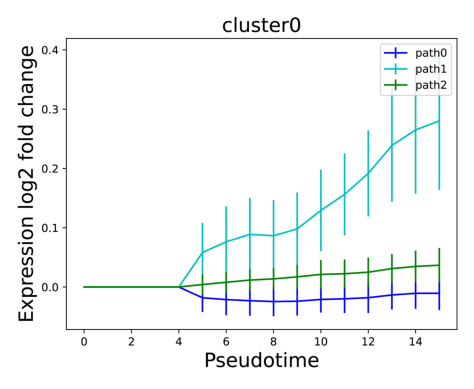

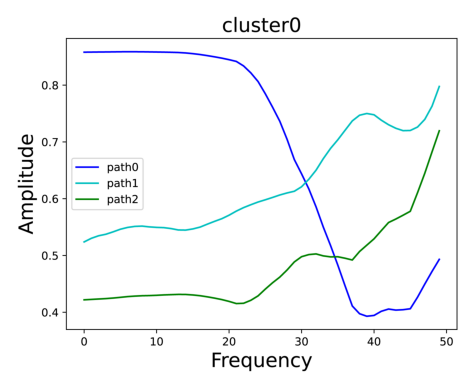

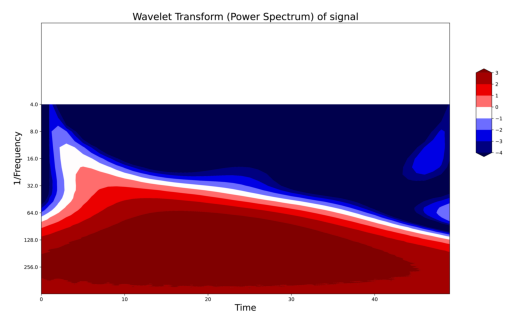

In [4]:
show_result_spatial(adata, start, end)

Only the first eligible cluster's plots are ploted out. Other clusters's plots are saved to pdf files.

# Part 4: Differential frequency peaks
In this step, we perform a comparative analysis to identify peaks that show significant differences in frequency between directions. By statistically evaluating these differences, we can uncover frequency-specific regulatory elements or patterns that are condition-dependent. This analysis provides deeper biological insights into how rhythmicity may vary across different genes in Spatial data, thereby highlighting potential functional elements involved in dynamic processes.

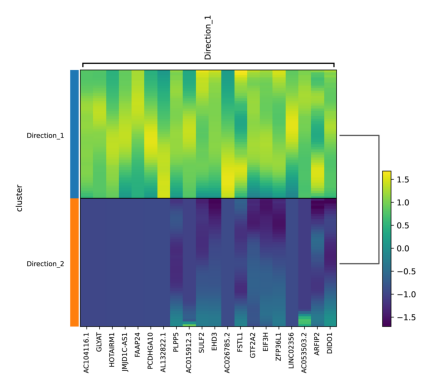

In [5]:
adata2 = adata.copy()
sc.pp.normalize_total(adata2)
sc.pp.log1p(adata2)
sc.pp.highly_variable_genes(adata2, flavor="seurat", n_top_genes=5000)

adata = adata[:, adata2.var.highly_variable]
 
# Extract spatial coordinates
spatial_coords = adata.obsm["spatial"]

# Locate the right boundary of WM cells
wm_indices = adata.obs['layer'] == 'WM'
wm_coords = spatial_coords[wm_indices]
wm_right_boundary = wm_coords[:, 0].max()  # Maximum x-coordinate for WM

# Define Direction 2: Bottom to WM right boundary
margin = 0.1  # 10% margin
x_start = spatial_coords[:, 0].min() + margin * (spatial_coords[:, 0].max() - spatial_coords[:, 0].min())
y_min, y_max = spatial_coords[:, 1].min(), spatial_coords[:, 1].max()

start1 = np.array([x_start, y_min + margin * (y_max - y_min)])  # Bottom with margin
end1 = np.array([wm_right_boundary, y_max - margin * (y_max - y_min)])  # WM right boundary with margin


# Define a single line from bottom-left to top-right
margin = 0.1  # 10% margin
x_min, x_max = spatial_coords[:, 0].min(), spatial_coords[:, 0].max()
y_min, y_max = spatial_coords[:, 1].min(), spatial_coords[:, 1].max()

# Add margin to the coordinates
# Add margin to the coordinates for Direction 3
y_start = y_min + margin * (y_max - y_min)  # Y coordinate with 10% margin
start2 = np.array([x_min + margin * (x_max - x_min), y_start])  # Left with margin
end2 = np.array([x_max - margin * (x_max - x_min), y_start])  # Right with margin

differential_frequency_spatial(adata, start1, end1, start2, end2, 'direction1', 'direction2')